In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import pickle as pkl

from koala.plotting import plot_vertex_indices, plot_degeneracy_breaking, plot_lattice
from koala import example_graphs as eg
from koala.pointsets import uniform
from koala.graph_utils import (
    lloyd_relaxation,
    vertex_neighbours,
    clockwise_edges_about,
    adjacent_plaquettes,
    remove_trailing_edges,
    make_dual,
    vertices_to_polygon,
    dimerise,
    remove_vertices,
    tile_unit_cell,
    untile_unit_cell,
    shift_vertex,
    dimer_collapse,
    com_relaxation,
    edge_spanning_tree,
    plquette_spanning_tree,
)
from koala.lattice import Lattice
from koala.voronization import generate_lattice
from koala import plotting as pl

# two test lattices
g = Lattice(
    vertices=np.array([[0.5, 0.5], [0.1, 0.1], [0.5, 0.9], [0.9, 0.1]]),
    edge_indices=np.array([[0, 1], [0, 2], [0, 3]]),
    edge_crossing=np.array([[0, 0], [0, 0], [0, 0]]),
)
points = uniform(30)
lattice = generate_lattice(points)

weird_graphs_simplified = [
    eg.tri_square_pent(),
    eg.two_triangles(),
    eg.tutte_graph(),
    eg.n_ladder(6, True),
    generate_lattice(points),
    eg.cut_boundaries(generate_lattice(points), [False, True]),
    eg.cut_boundaries(generate_lattice(points), [True, True]),
    eg.honeycomb_lattice(12),
]

import matplotlib.pyplot as plt

In [3]:
def _sp_tree_test(lattice: Lattice):

    for s_edge in [True, False]:
        for c_bound in [True, False]:
            sp = edge_spanning_tree(lattice, s_edge, c_bound)
            vertices_in_sp = np.unique(lattice.edges.indices[sp])
            assert len(vertices_in_sp) == lattice.n_vertices


def _plaq_tree_test(lattice: Lattice):

    for s_edge in [True, False]:
        for c_bound in [True, False]:
            sp = plquette_spanning_tree(lattice, s_edge, c_bound)
            plaqs_in_sp = np.unique(lattice.edges.adjacent_plaquettes[sp])
            assert len(plaqs_in_sp) == lattice.n_plaquettes


for n in range(10):
    points = uniform(20)
    graph = generate_lattice(points)
    graph = remove_trailing_edges(graph)
    print(graph)
    _sp_tree_test(graph)
    _plaq_tree_test(graph)

Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)
Lattice(40 vertices, 60 edges)


<Axes: >

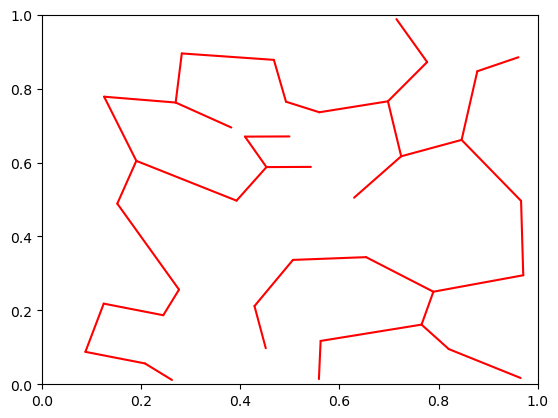

In [4]:
from koala import plotting as pl

e = edge_spanning_tree(graph, False, False)
# pl.plot_edges(graph)
pl.plot_edges(graph, color_scheme=["r"], subset=e)

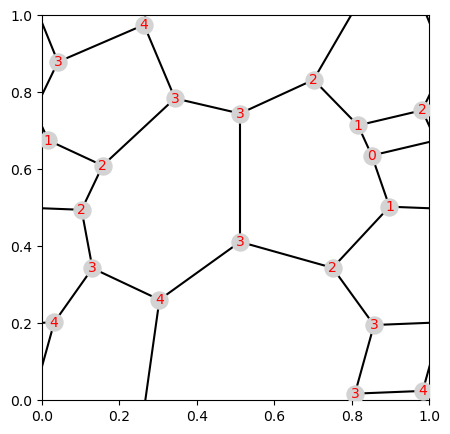

In [5]:
lattice.adjacency_matrix * 1

points = uniform(10)
lattice = generate_lattice(points)


def distance_matrix(lattice: Lattice) -> np.ndarray:
    """Creates a distance matrix for the distance from every vertex to
    every other vertex in the shortest number of steps

    Args:
        lattice (Lattice): The lattice object

    Returns:
        np.ndarray: A distance matrix
    """

    M = lattice.adjacency_matrix
    distance_matrix = np.full((lattice.n_vertices, lattice.n_vertices), -1)
    current_power = np.eye(lattice.n_vertices)
    for u in range(lattice.n_vertices):
        current_power = current_power @ M
        spots_to_fill = np.where(distance_matrix == -1)
        if len(spots_to_fill[0]) == 0:
            break
        filled_in_m = np.where(current_power != 0)

        new_distances = np.full((lattice.n_vertices, lattice.n_vertices), -1)
        new_distances[filled_in_m] = u + 1
        distance_matrix[spots_to_fill] = new_distances[spots_to_fill]

    distance_matrix = (1 - np.eye(lattice.n_vertices, dtype=int)) * distance_matrix
    return distance_matrix


def test_distance_matrix():
    for graph in weird_graphs_simplified:
        dis = distance_matrix(graph)
        v = dis[0]
        edge = v[graph.edges.indices]
        assert np.all(np.abs(np.diff(edge)) <= 1)


fig, ax = plt.subplots(figsize=(5, 5))
d_mat = distance_matrix(lattice)
pl.plot_edges(lattice)

row = 1
v = d_mat[row]
for i in range(lattice.n_vertices):
    plt.scatter(*lattice.vertices.positions[i], c="lightgrey", s=150, zorder=10)
    plt.annotate(
        v.T[i],
        lattice.vertices.positions[i],
        c="r",
        zorder=11,
        ha="center",
        va="center",
    )

12 12


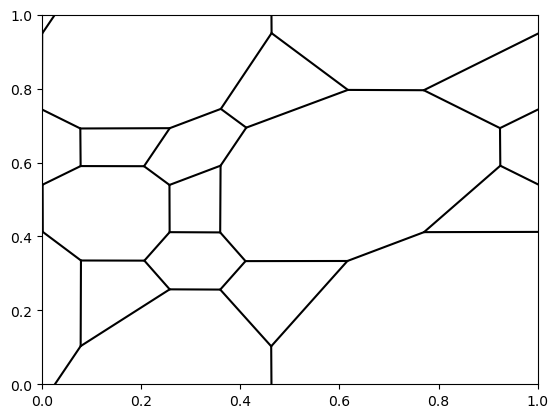

In [6]:
from dimer_models.lattice_generation import bipartite_squarefull
from koala import graph_utils as gu

l = bipartite_squarefull(35, True)
pl.plot_edges(l)

x_loop_len = len(gu.find_periodic_loop(l, "x"))
y_loop_len = len(gu.find_periodic_loop(l, "y"))

print(x_loop_len, y_loop_len)

<Axes: >

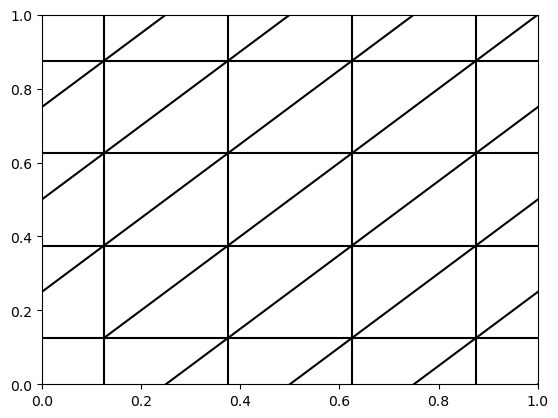

In [7]:
from koala.example_graphs import triangular_lattice

lat = triangular_lattice(4, 4)

pl.plot_edges(lat)

In [13]:
import pfapack
import pfapack.pfaffian as pf

m = np.random.random([10, 10])
m = m - m.T

In [14]:
import pfapack
from pfapack.ctypes import pfaffian as cpf

p = pf.pfaffian(m, avoid_overflow=True)

t1 = pf.skew_tridiagonalize(m, False, False)
t2 = pf.skew_LTL(m, False, False)

p
a1 = t1.diagonal(1)
a2 = t2[0].diagonal(1)

print(p, np.prod(a1), np.prod(a2))

TypeError: pfaffian() got an unexpected keyword argument 'avoid_overflow'

In [ ]:
import pfapack.ctypes as cpf
import pfapack.pfaffian
import ctypes

n = 1000
matrix = np.random.random([n, n])
matrix = matrix - matrix.T

pf_val = cpf.pfaffian(matrix)
fort_pfa = cpf._init("skpf10_d")

matrix_f = np.asarray(matrix, dtype=np.float64, order="F")
result_array = (ctypes.c_double * 2)(0.0, 0.0)
uplo_bytes = "U".encode()
method_bytes = "P".encode()
fort_pfa(matrix.shape[0], matrix_f, result_array, uplo_bytes, method_bytes)

print(result_array)

In [ ]:
print(result_array[0])
print(result_array[1])
print(pf_val)

9.373488379994713
445.0
inf


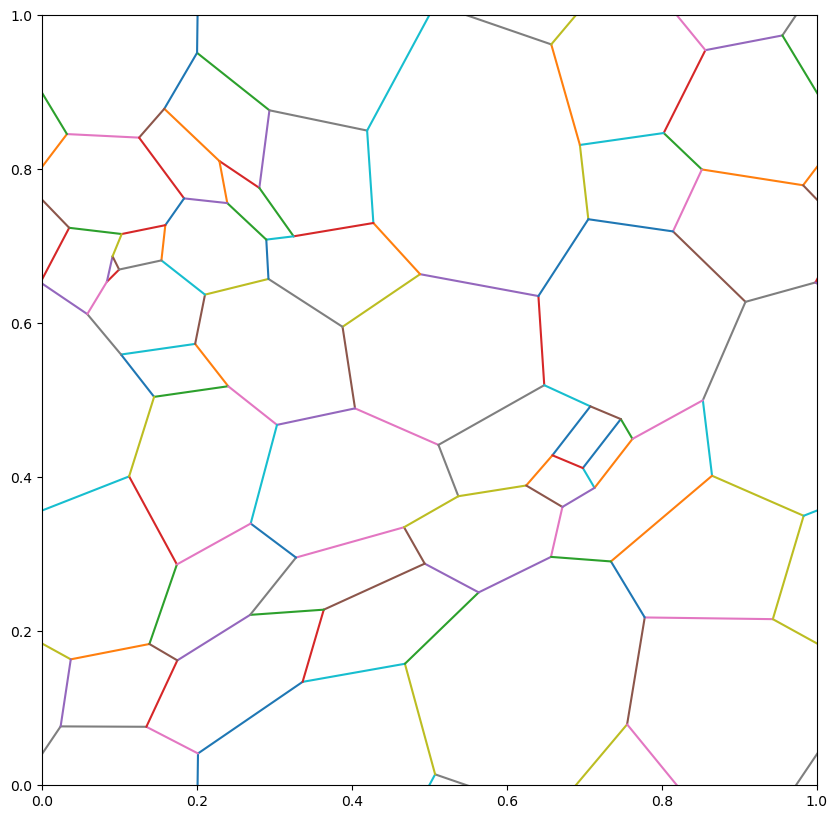

In [ ]:
lat = generate_lattice(uniform(40))


edge_labels = np.arange(lat.n_edges)
cmap = plt.get_cmap("tab10")
color_scheme = cmap(np.arange(10))

fig, ax = plt.subplots(figsize=(10, 10))
pl.plot_edges(lat, labels=edge_labels, color_scheme=(color_scheme))

plt.show()

In [ ]:
n_dims

[9, 1]
(3, 4)
(27, 4)


2

In [ ]:
x = [
    0,
    0,
    1,
    0,
    1,
    1,
    2,
    2,
    8,
    8,
    32,
    57,
    185,
    466,
    1543,
    4583,
    15374,
    50116,
    171168,
    582603,
    2024119,
    7057472,
    24873248,
    88111772,
    314301078,
    1126716000,
    4060375677,
    14697571234,
    53432834170,
    195015189626,
    714404259151,
    2626130395699,
]

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 2.00000000e+00 5.00000000e+00 1.40000000e+01
 5.00000000e+01 1.82000000e+02 6.66000000e+02 2.44200000e+03
 8.95600000e+03 3.28610000e+04 1.20573000e+05 4.42414000e+05
 1.62334700e+06 5.95653900e+06 2.18563060e+07 8.01972680e+07
 2.94267567e+08 1.07975500e+09 3.96194142e+09 1.45375385e+10
 5.33425414e+10 1.95729609e+11 7.18190004e+11 2.63525219e+12]


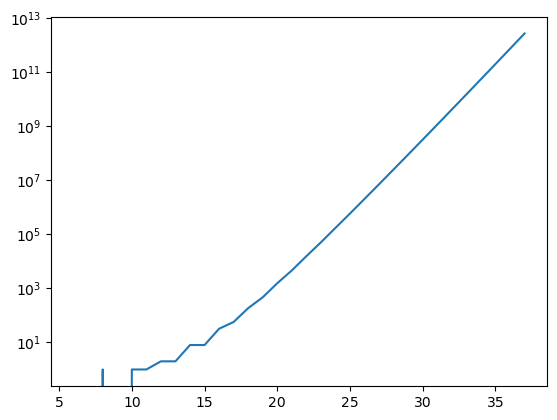

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale("log")
u = np.arange(6, 6 + len(x))

# plt.plot(u,x)
v = (1 + np.round(np.exp(1.3 * (u - 15)))).astype("int")
# plt.plot(u, v )
plt.plot(u, x)
print(1 + np.round(np.exp(1.3 * (u - 15))))

In [ ]:
from scipy import linalg as la

H = 1 * np.eye(4) - np.array(
    [[0, 1, 0, 1], [-1, 0, 1, 0], [0, -1, 0, 1], [-1, 0, -1, 0]]
)
np.round(la.inv(H), 5)

array([[ 0.33333,  0.33333,  0.     ,  0.33333],
       [-0.33333,  0.33333,  0.33333, -0.     ],
       [ 0.     , -0.33333,  0.33333,  0.33333],
       [-0.33333,  0.     , -0.33333,  0.33333]])

In [ ]:
np.round(H @ H.T, 4)

array([[3., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 3., 0.],
       [0., 0., 0., 3.]])

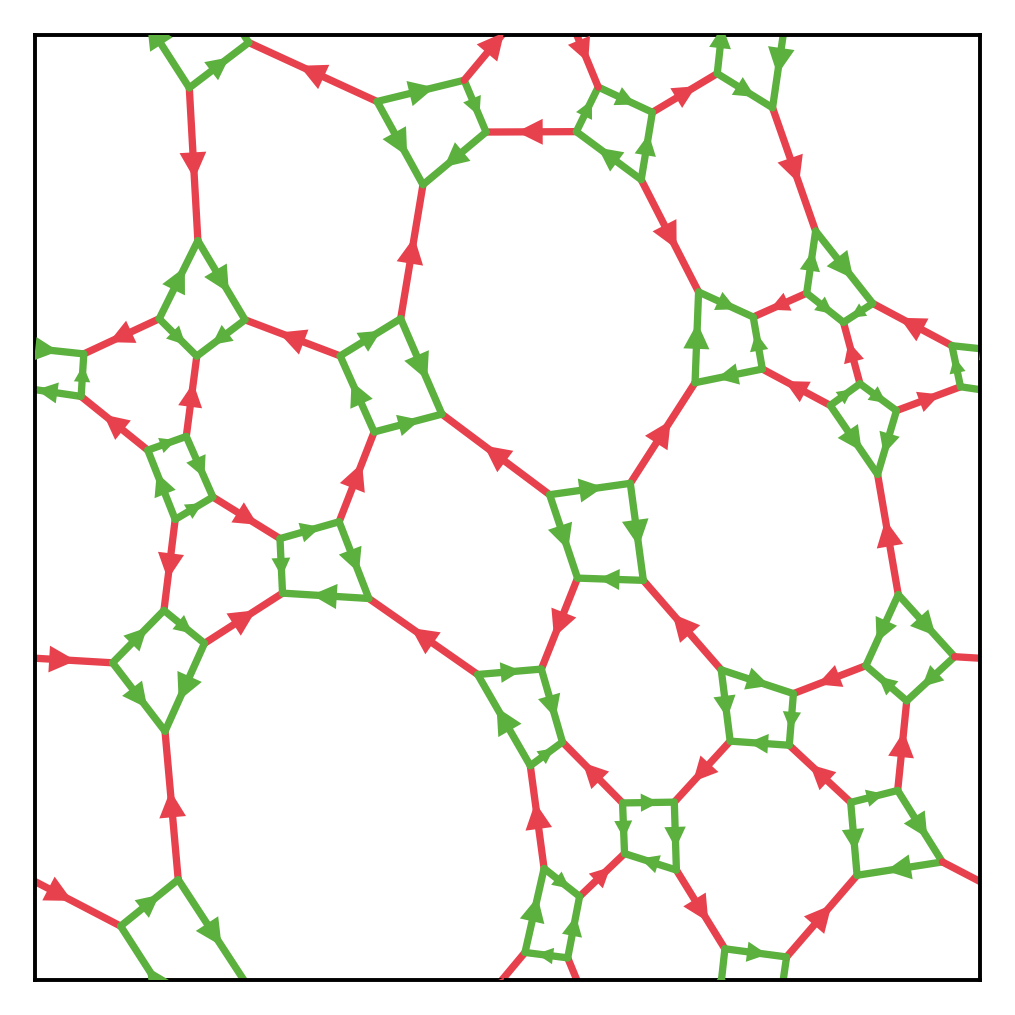

In [15]:
from koala.flux_finder import ujk_from_fluxes

lat_square = gu.com_relaxation(bipartite_squarefull(80, ensure_true_bipartite=True))
orientation = ujk_from_fluxes(lat_square, [-1] * lat_square.n_plaquettes)
labels = [0] * (2 * lat_square.n_edges // 6) + [1] * (4 * lat_square.n_edges // 6)


fig, ax = plt.subplots(figsize=(3, 3), dpi=350)
pl.plot_edges(lat_square, labels=labels, directions=orientation)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("lattice.png")

In [44]:
from scipy import linalg as la

n = 8

h_loop = np.eye(n, n, 1) + np.eye(n, n, n - 1) - np.eye(n, n, -1) - np.eye(n, n, -n + 1)
u = 0.3


# np.round(la.inv(u * np.eye(4) + h_loop), 6)
l = 0.3
print(np.round(la.inv(h_loop + l * np.eye(n)), 5))

print(
    1 / (l**2 + 2),
    l / (l**2 + 2),
)
h_loop

[[ 0.26477 -0.46028  0.12668 -0.42228  0.      -0.42228 -0.12668 -0.46028]
 [ 0.46028  0.26477 -0.46028  0.12668 -0.42228 -0.      -0.42228 -0.12668]
 [ 0.12668  0.46028  0.26477 -0.46028  0.12668 -0.42228  0.      -0.42228]
 [ 0.42228  0.12668  0.46028  0.26477 -0.46028  0.12668 -0.42228 -0.     ]
 [ 0.       0.42228  0.12668  0.46028  0.26477 -0.46028  0.12668 -0.42228]
 [ 0.42228  0.       0.42228  0.12668  0.46028  0.26477 -0.46028  0.12668]
 [-0.12668  0.42228  0.       0.42228  0.12668  0.46028  0.26477 -0.46028]
 [ 0.46028 -0.12668  0.42228 -0.       0.42228  0.12668  0.46028  0.26477]]
0.47846889952153115 0.14354066985645933


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  1.],
       [-1.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
n = 10
h_loop = np.eye(n, n, 1) + np.eye(n, n, n - 1) - np.eye(n, n, -1) - np.eye(n, n, -n + 1)
h_loop @ h_loop @ h_loop @ h_loop @ h_loop @ h_loop

array([[-20.,   0.,  15.,   0.,  -7.,   0.,   7.,   0., -15.,   0.],
       [  0., -20.,   0.,  15.,   0.,  -7.,   0.,   7.,   0., -15.],
       [ 15.,   0., -20.,   0.,  15.,   0.,  -7.,   0.,   7.,   0.],
       [  0.,  15.,   0., -20.,   0.,  15.,   0.,  -7.,   0.,   7.],
       [ -7.,   0.,  15.,   0., -20.,   0.,  15.,   0.,  -7.,   0.],
       [  0.,  -7.,   0.,  15.,   0., -20.,   0.,  15.,   0.,  -7.],
       [  7.,   0.,  -7.,   0.,  15.,   0., -20.,   0.,  15.,   0.],
       [  0.,   7.,   0.,  -7.,   0.,  15.,   0., -20.,   0.,  15.],
       [-15.,   0.,   7.,   0.,  -7.,   0.,  15.,   0., -20.,   0.],
       [  0., -15.,   0.,   7.,   0.,  -7.,   0.,  15.,   0., -20.]])

In [56]:
n = 4
h_loop = np.eye(n, n, 1) + np.eye(n, n, n - 1) - np.eye(n, n, -1) - np.eye(n, n, -n + 1)
e = la.eigvals(h_loop)
e

array([-1.63456285e-17+1.41421356j, -1.63456285e-17-1.41421356j,
       -1.34692639e-17+1.41421356j, -1.34692639e-17-1.41421356j])